Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.4


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

('n02504013', 'Indian_elephant', 0.9683744)
('n02504458', 'African_elephant', 0.01700191)
('n01871265', 'tusker', 0.003533815)
('n06359193', 'web_site', 0.0007669711)
('n01694178', 'African_chameleon', 0.00036488983)


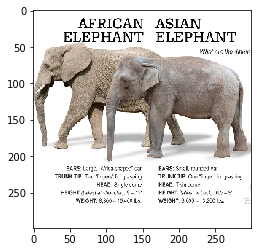

In [4]:
images = transform_img_fn([os.path.join('data','asian-african-elephants.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

In [5]:
from keras.utils import get_file
import json

def get_class_index(name):
    """Get the index of a item in ImageNet model."""

    name = name.lower()
    fpath = get_file('imagenet_class_index.json',
                     'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json',
                     cache_subdir='models',
                     file_hash='c2c37ea517e94d9795004a39431a14cb')
    with open(fpath) as f:
        classes = json.load(f)
    for k, v in classes.items():
        if v[1].lower() == name:
            return int(k)
    return None

In [6]:
Indian_elephant = get_class_index("Indian_elephant")
Indian_elephant

385

In [7]:
African_elephant = get_class_index("African_elephant")
African_elephant

386

## Explanation
Now let's get an explanation

In [8]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [9]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [10]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

Wall time: 21.9 s


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class (Indian_elephant and African_elephant)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [11]:
from skimage.segmentation import mark_boundaries

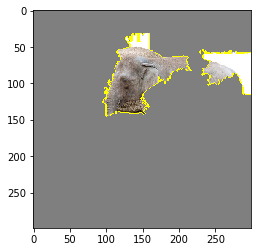

In [12]:
temp, mask = explanation.get_image_and_mask(Indian_elephant, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

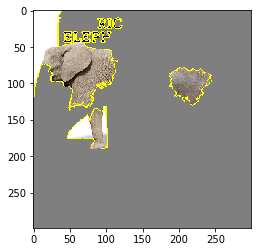

In [13]:
temp, mask = explanation.get_image_and_mask(African_elephant, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:
```python
hide_rest=False
```

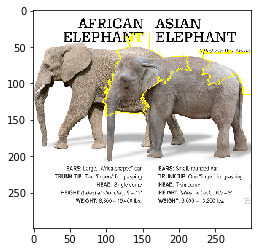

In [14]:
temp, mask = explanation.get_image_and_mask(Indian_elephant, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

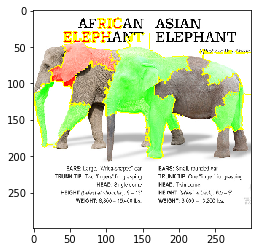

In [15]:
temp, mask = explanation.get_image_and_mask(Indian_elephant, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

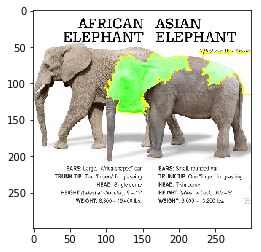

In [16]:
temp, mask = explanation.get_image_and_mask(Indian_elephant, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))